In [1]:
%install-location $cwd/swift-install
%install '.package(path: "$cwd/swiftai")' SwiftAI

Installing packages:
	.package(path: "/home/mlk/swift/swiftai")
		SwiftAI
With SwiftPM flags: []
Working in: /tmp/tmpg5ksl7nh/swift-install
/home/mlk/swift/usr/bin/swift: /home/mlk/anaconda3/envs/fai/lib/libuuid.so.1: no version information available (required by /home/mlk/swift/usr/bin/swift)
/home/mlk/swift/usr/bin/swift: /home/mlk/anaconda3/envs/fai/lib/libuuid.so.1: no version information available (required by /home/mlk/swift/usr/bin/swift)
/home/mlk/swift/usr/bin/swift: /home/mlk/anaconda3/envs/fai/lib/libuuid.so.1: no version information available (required by /home/mlk/swift/usr/bin/swift)
/home/mlk/swift/usr/bin/swift: /home/mlk/anaconda3/envs/fai/lib/libuuid.so.1: no version information available (required by /home/mlk/swift/usr/bin/swift)
/home/mlk/swift/usr/bin/swiftc: /home/mlk/anaconda3/envs/fai/lib/libuuid.so.1: no version information available (required by /home/mlk/swift/usr/bin/swiftc)
/home/mlk/swift/usr/bin/swiftc: /home/mlk/anaconda3/envs/fai/lib/libuuid.so.1: no v

In [2]:
import SwiftAI
import TensorFlow
import Python
%include "EnableIPythonDisplay.swift"
IPythonDisplay.shell.enable_matplotlib("inline")
let plt = Python.import("matplotlib.pyplot")
let np = Python.import("numpy")
import Foundation
import Just
import Path

In [3]:
let d = mnistDataBunch(path: Path.home/"swift", flat: true, bs: 256)

2019-11-28 01:49:31.067463: W tensorflow/core/framework/cpu_allocator_impl.cc:81] Allocation of 188160000 exceeds 10% of system memory.
2019-11-28 01:49:31.162483: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX
2019-11-28 01:49:31.220274: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2019-11-28 01:49:31.223148: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2019-11-28 01:49:31.223784: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: GeForce GTX 970 major: 5 minor: 2 memoryClockRate(GHz): 1.253
pciBusID: 0000:01:00.0
2019-11-28 01:49:31.257123: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened

In [4]:
d.train.ds.first(where: { _ in true })!.xb.shape

▿ [256, 784]
  ▿ dimensions : 2 elements
    - 0 : 256
    - 1 : 784


In [5]:
//MLP model with 2 hidden layers
public struct MyModel: Layer {
    public var hidden1: FADense<Float>
    public var hidden2: FADense<Float>
    public var out:     FADense<Float>
    
    public init(nIn: Int, nHid1: Int, nHid2: Int, nOut: Int){
        hidden1 = FADense(nIn, nHid1, activation: relu)
        hidden2 = FADense(nHid1, nHid2, activation: relu)
        out =     FADense(nHid2, nOut)
    }
    
    @differentiable
    public func callAsFunction(_ input: TF) -> TF {
        return out(hidden2(hidden1(input)))
    }
}


In [6]:
func modelInit() -> MyModel { return MyModel(nIn: 784,nHid1: 2048, nHid2: 512, nOut: 10) }

In [7]:
// Source: http://cs231n.github.io/neural-networks-3/#sgd

public extension StateKeys {
    static let prevGrad = "previousAverageGrad"
}

public struct PreviousAverageGrad: StatDelegate {
    public var defaultHPs: [String:Float] { return [:] }
    public var name: String { return StateKeys.prevGrad }
    public func update(_ state: inout [String: TF], p: TF, 𝛁p: TF, hps: inout [String:Float]) {
        state[StateKeys.prevGrad]! = state[StateKeys.avgGrad]!
    }
}

public struct AvgGrad: StatDelegate {
    public var defaultHPs: [String: Float] { return [HyperParams.mom: 0.9] }
    public let dampened: Bool
    public init(dampened: Bool = false) { self.dampened = dampened }
    public var name: String { return StateKeys.avgGrad }
    public func update(_ state: inout [String: TF], p: TF, 𝛁p: TF, hps: inout [String:Float]) {
        state[StateKeys.avgGrad]! *= hps[HyperParams.mom]!
        hps[HyperParams.momDamp] = 1.0 - (dampened ? hps[HyperParams.mom]! : 0.0)
        state[StateKeys.avgGrad]! -= hps[HyperParams.lr]! * 𝛁p
    }
}

public struct NesterovStep: StepDelegate {
    public var defaultHPs: [String: Float] { return [HyperParams.mom: 0.9]}
    public init() {}
    public func update(_ p: inout TF, 𝛁p: inout TF, 
                       state: [String : TF], 
                       hps: inout [String : Float]){
        p += -hps[HyperParams.mom]! * state[StateKeys.prevGrad]! + ( 1 + hps[HyperParams.mom]!) * state[StateKeys.avgGrad]!
    }
}


In [8]:
public struct L1: StepDelegate {
    public var defaultHPs: [String: Float] { return [HyperParams.wd: 0] }
    public init() {}
    public func update(_ p: inout TF, 𝛁p: inout TF, state: [String:TF], hps: inout [String:Float]) {
        𝛁p += hps[HyperParams.wd]! * abs(p).sum()
    }
}

public struct L2: StepDelegate {
    public var defaultHPs: [String: Float] { return [HyperParams.wd: 0] }
    public init() {}
    public func update(_ p: inout TF, 𝛁p: inout TF, state: [String:TF], hps: inout [String:Float]) {
        𝛁p += hps[HyperParams.wd]! * p
    }
}

# MLP 1 with SGD

In [9]:
func sgd(_ model: MyModel) -> StatefulOptimizer<MyModel> {
    return StatefulOptimizer(for: model, 
                             steppers: [SGDStep()], 
                             stats: [], 
                             hps: [HyperParams.lr: 0.01])
}

let learner_sgd = Learner(
                    data: d, 
                    lossFunc: crossEntropy, 
                    optFunc: sgd, 
                    modelInit: modelInit)

let recorder_sgd = learner_sgd.makeDefaultDelegates(metrics: [accuracy])
learner_sgd.addDelegates([learner_sgd.makeNormalize(mean: mnistStats.mean, std: mnistStats.std)])

In [10]:
try! learner_sgd.fit(25)

2019-11-28 01:49:48.966748: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10.0
Epoch 0: Train: [0.712534, 0.82565] , Valid:[0.3681209, 0.9045]                
Epoch 1: Train: [0.33626172, 0.90793335] , Valid:[0.28671396, 0.9198]          
Epoch 2: Train: [0.2783387, 0.9217] , Valid:[0.25160962, 0.9287]               
Epoch 3: Train: [0.24597731, 0.9308] , Valid:[0.22659527, 0.9373]              
Epoch 4: Train: [0.22282189, 0.9372] , Valid:[0.21315499, 0.9425]              
Epoch 5: Train: [0.20491463, 0.9421667] , Valid:[0.19796985, 0.9438]           
Epoch 6: Train: [0.19000591, 0.9467] , Valid:[0.18377434, 0.9476]              
Epoch 7: Train: [0.17753296, 0.9505] , Valid:[0.17509036, 0.9495]              
Epoch 8: Train: [0.16660862, 0.9533833] , Valid:[0.16453502, 0.9516]            
Epoch 9: Train: [0.15692325, 0.95606667] , Valid:[0.1592812, 0.9519]           
Epoch 10: Train: [0.14840187, 0.9586667] , Valid:[0.1

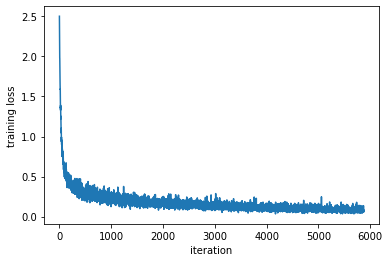

In [11]:
recorder_sgd.plotLosses()

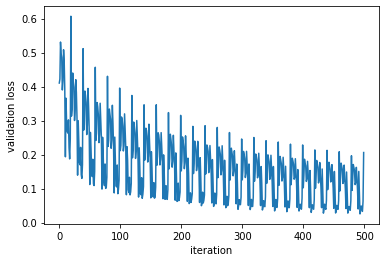

In [12]:
recorder_sgd.plotValidLosses()

# MLP 2 with  Nesterov

In [13]:
func sgdnest_opt(_ model: MyModel) -> StatefulOptimizer<MyModel> {
    return StatefulOptimizer(for: model, 
                             steppers: [NesterovStep()], 
                             stats: [PreviousAverageGrad(),AvgGrad()], 
                             hps: [HyperParams.lr: 0.01])
}

let learner_nest = Learner(
                    data: d, 
                    lossFunc: crossEntropy, 
                    optFunc: sgdnest_opt, 
                    modelInit: modelInit)

let recorder_nest = learner_nest.makeDefaultDelegates(metrics: [accuracy])
learner_nest.addDelegates([learner_nest.makeNormalize(mean: mnistStats.mean, std: mnistStats.std)])

In [14]:
try! learner_nest.fit(25)

Epoch 0: Train: [0.32689664, 0.90501666] , Valid:[0.16297495, 0.9537]          
Epoch 1: Train: [0.1407263, 0.96078336] , Valid:[0.11852196, 0.9645]           
Epoch 2: Train: [0.09820437, 0.9724333] , Valid:[0.096560955, 0.9696]          
Epoch 3: Train: [0.07385254, 0.97941667] , Valid:[0.09317045, 0.9715]          
Epoch 4: Train: [0.057408288, 0.9841] , Valid:[0.07935907, 0.9764]             
Epoch 5: Train: [0.045116715, 0.9884833] , Valid:[0.07189974, 0.9782]          
Epoch 6: Train: [0.03592775, 0.99111664] , Valid:[0.0701974, 0.9786]           
Epoch 7: Train: [0.028542155, 0.9935667] , Valid:[0.066030465, 0.9788]         
Epoch 8: Train: [0.02258984, 0.9956667] , Valid:[0.06658802, 0.9793]           
Epoch 9: Train: [0.018693939, 0.99666667] , Valid:[0.06267533, 0.981]          
Epoch 10: Train: [0.015001452, 0.99785] , Valid:[0.06226653, 0.9802]           
Epoch 11: Train: [0.012536412, 0.99865] , Valid:[0.06211086, 0.9808]           
Epoch 12: Train: [0.010150569, 0.99905] 

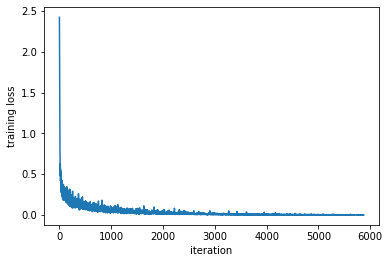

In [15]:
recorder_nest.plotLosses()

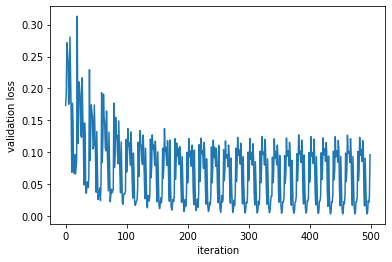

In [16]:
recorder_nest.plotValidLosses()

# MLP 3 with Nesterov and L1

In [17]:
//Optimizer with Nesterov step and L1 regularizer
func optFunc(_ model: MyModel) -> StatefulOptimizer<MyModel> {
    return StatefulOptimizer(for: model, 
                             steppers: [NesterovStep(), L1()], 
                             stats: [PreviousAverageGrad(),AvgGrad()], 
                             hps: [HyperParams.lr: 0.01, HyperParams.wd: 0.02])
}

let learner_nest_l1 = Learner(
                    data: d, 
                    lossFunc: crossEntropy, 
                    optFunc: optFunc, 
                    modelInit: modelInit)

let recorder_nest_l1 = learner_nest_l1.makeDefaultDelegates(metrics: [accuracy])
learner_nest_l1.addDelegates([learner_nest_l1.makeNormalize(mean: mnistStats.mean, std: mnistStats.std)])

In [18]:
learner_nest_l1.fit(25)

Epoch 0: Train: [0.32841176, 0.9044333] , Valid:[0.16432396, 0.952]            
Epoch 1: Train: [0.1398538, 0.95995] , Valid:[0.12543121, 0.9621]              
Epoch 2: Train: [0.098099016, 0.9726] , Valid:[0.10273668, 0.9688]             
Epoch 3: Train: [0.07338744, 0.97985] , Valid:[0.0840514, 0.9743]              
Epoch 4: Train: [0.056948684, 0.9842167] , Valid:[0.07829698, 0.9772]          
Epoch 5: Train: [0.04509399, 0.98828334] , Valid:[0.07227907, 0.9775]           
Epoch 6: Train: [0.035668436, 0.99128336] , Valid:[0.06754822, 0.9805]         
Epoch 7: Train: [0.028384697, 0.9939833] , Valid:[0.067810595, 0.9789]         
Epoch 8: Train: [0.023582755, 0.9949833] , Valid:[0.063821316, 0.979]          
Epoch 9: Train: [0.018646793, 0.9968167] , Valid:[0.061882466, 0.9805]         
Epoch 10: Train: [0.015292067, 0.99763334] , Valid:[0.060950123, 0.9813]       
Epoch 11: Train: [0.012465171, 0.9986] , Valid:[0.060580883, 0.9818]           
Epoch 12: Train: [0.010394278, 0.998966

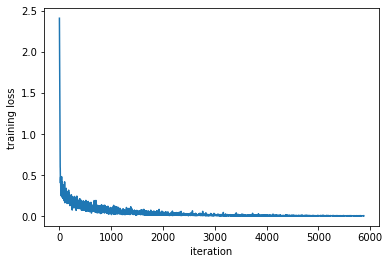

In [19]:
recorder_nest_l1.plotLosses()

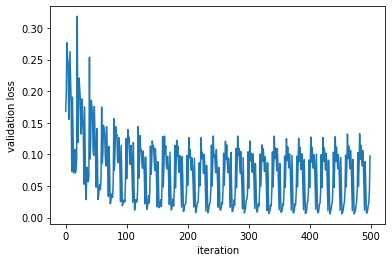

In [20]:
recorder_nest_l1.plotValidLosses()

# MLP 4 with Nesterov and L2

In [21]:
func SGD_nest_L2(_ model: MyModel) -> StatefulOptimizer<MyModel> {
    return StatefulOptimizer(for: model, 
                             steppers: [NesterovStep(), L2()], 
                             stats: [PreviousAverageGrad(),AvgGrad()], 
                             hps: [HyperParams.lr: 0.01, HyperParams.wd: 0.02])
}

let learner_nest_l2 = Learner(
                    data: d, 
                    lossFunc: crossEntropy, 
                    optFunc: SGD_nest_L2, 
                    modelInit: modelInit)

let recorder_nest_l2 = learner_nest_l2.makeDefaultDelegates(metrics: [accuracy])
learner_nest_l2.addDelegates([learner_nest_l2.makeNormalize(mean: mnistStats.mean, std: mnistStats.std)])

In [22]:
learner_nest_l2.fit(25)

Epoch 0: Train: [0.33119026, 0.90491664] , Valid:[0.17028119, 0.9502]          
Epoch 1: Train: [0.14299934, 0.95925] , Valid:[0.12137368, 0.9627]             
Epoch 2: Train: [0.09939466, 0.97211665] , Valid:[0.10129041, 0.9687]           
Epoch 3: Train: [0.07397377, 0.9795667] , Valid:[0.08422395, 0.9741]           
Epoch 4: Train: [0.05731585, 0.98448336] , Valid:[0.0773645, 0.9758]           
Epoch 5: Train: [0.04513752, 0.98826665] , Valid:[0.07031785, 0.9773]          
Epoch 6: Train: [0.03558304, 0.9910833] , Valid:[0.066094875, 0.9787]           
Epoch 7: Train: [0.028643975, 0.99305] , Valid:[0.0670735, 0.9786]             
Epoch 8: Train: [0.022938501, 0.9953667] , Valid:[0.06341174, 0.9793]          
Epoch 9: Train: [0.018683918, 0.9967167] , Valid:[0.06231548, 0.9797]          
Epoch 10: Train: [0.015428478, 0.99761665] , Valid:[0.05901662, 0.9806]        
Epoch 11: Train: [0.012580004, 0.99845] , Valid:[0.061107147, 0.98]            
Epoch 12: Train: [0.01040649, 0.99905]

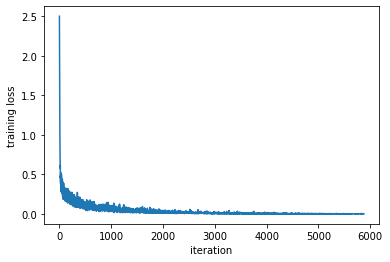

In [23]:
recorder_nest_l2.plotLosses()

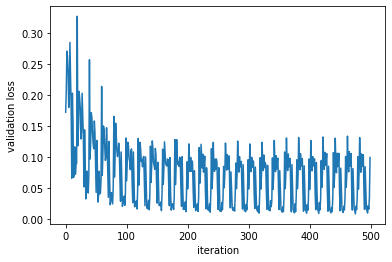

In [24]:
recorder_nest_l2.plotValidLosses()

In [25]:
let y = Array(0..<recorder_nest_l2.losses.count)
let sgd: Array<Float>     = recorder_sgd.losses.compactMap{$0.scalar}
let nest: Array<Float>    = recorder_nest.losses.compactMap{$0.scalar}
let nest_l1: Array<Float> = recorder_nest_l1.losses.compactMap{$0.scalar}
let nest_l2: Array<Float> = recorder_nest_l2.losses.compactMap{$0.scalar}


In [26]:
//Smooth our loss so we can actually see something
func smooth_curve(points:Array<Float>, factor:Float=0.9) -> Array<Float> {
    var smoothed_points: Array<Float> = Array()
    let x1 = points.first
    smoothed_points.append(x1!)
    var points_ = points.dropFirst()
    for point in points_{
            let previous = smoothed_points.last
            let smth = previous! * factor + point * (1 - factor)
            smoothed_points.append(smth)
    }
        
    return smoothed_points
}
    

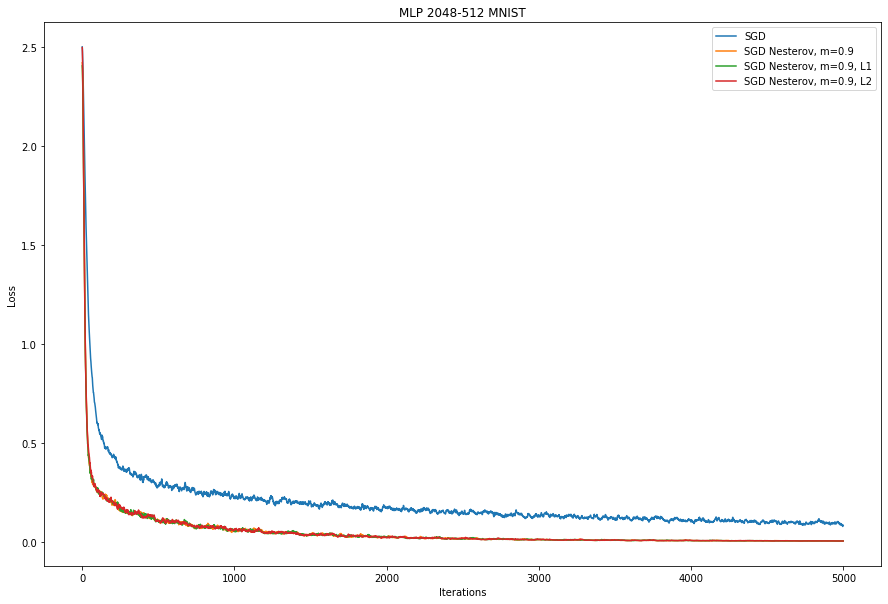

None


In [27]:
plt.figure(figsize: [15, 10])
let i = 0
let n = 5000
let y2 = Array(y[i..<n])
plt.plot(y2,smooth_curve(points: Array(sgd[i..<n])), label:"SGD")
plt.plot(y2,smooth_curve(points: Array(nest[i..<n])), label:"SGD Nesterov, m=0.9")
plt.plot(y2,smooth_curve(points: Array(nest_l1[i..<n])), label:"SGD Nesterov, m=0.9, L1")
plt.plot(y2,smooth_curve(points: Array(nest_l2[i..<n])), label:"SGD Nesterov, m=0.9, L2")
plt.legend()
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("MLP 2048-512 MNIST")
plt.show()